In [2]:
import pandas as pd
import numpy as np
import time
import pickle
import re 
import matplotlib.pyplot as plt
import nvstrings
import warnings
import cudf as gd
import torch
import torch.nn

from numba import cuda
from sklearn.metrics import roc_auc_score
from datetime import date
from fastai.callbacks import *
from fastai import *
from fastai.tabular import *
from fastai.text import *
from fastai.metrics import accuracy
from multiprocessing import Process
from os import listdir
from os.path import isfile, join
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
import os
GPU_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [4]:
torch.cuda.current_device()

0


<h2> Functions </h2>

In [57]:
#########################
#                       #
# Metrics and callbacks #
#                       #
#########################

def write_pkl(obj, file_path=None):
    if not file_path:
        date_time = date.fromtimestamp(time.time()).strftime("%m_%d_%Y_%H-%M-%S")
        file_path=f'{date_time}.csv'
    if os.path.exists(file_path):
        os.remove(file_path)
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj, protocol=4)
    with open(file_path, 'wb') as f_out:
        for idx in range(0, len(bytes_out), max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def get_mean_reciprocal_rank(sub):
    # sub is a pandas dataframe
    # sub should have the following columns:
    # 'row_id', 'prob', 'reference', 'item_id'
    # sorted by prob in descending order for each group
    sub = gd.from_pandas(sub)
    
    def get_order_in_group(prob,row_id,order):
        for i in range(cuda.threadIdx.x, len(prob), cuda.blockDim.x):
            order[i] = i

    dg = sub.groupby('row_id',method="cudf").apply_grouped(get_order_in_group,incols=['prob','row_id'],
                                  outcols={'order': np.int32},
                                  tpb=32)

    dg = dg.to_pandas()
    dg['order'] = 1.0/(1+dg['order'])
    dg = dg[dg['reference']==dg['item_id']]
    return dg['order'].mean()

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

# Callback to calculate AUC at the end of each epoch
class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []

    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)

    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

        
def get_idx(x): 
    return 0 if pd.isnull(x) else id_to_index.get(str(x), 0)

<h1> <center> Data Processing </center> </h1>

### 1. If data is not saved before

In [ ]:
with open('cache/id_to_index.pkl', 'rb') as handle:
    id_to_index = pickle.load(handle)

In [ ]:
%%time
#load tabular data 
data_pair = pd.read_pickle('cache/data_pair_all.pkl')
data_pair = data_pair.drop(columns = [c for c in data_pair.columns if c.startswith('delta') or c.startswith('is')])

In [ ]:
%%time
data_context = pd.read_csv('cache/context_info.csv')
data_context['past_clickout_item'] = data_context['past_clickout_item'].apply(get_idx)
data_context['future_clickout_item'] = data_context['future_clickout_item'].apply(get_idx)

In [ ]:
%%time
data_pair = data_pair.merge(data_context, on='row_id', how='left')

In [ ]:
data_pair['past_clickout_price_diff'] = data_pair['price'] - data_pair['past_clickout_price']
data_pair['future_clickout_price_diff'] = data_pair['price'] - data_pair['future_clickout_price']

### 2. Otherwise, load the data

In [40]:
%%time
data_pair = pd.read_pickle('cache/data_pair_context.pkl')

CPU times: user 12.4 s, sys: 17.9 s, total: 30.2 s
Wall time: 30.2 s


In [41]:
data_pair.columns

Index(['row_id', 'candidate_order', 'item_id', 'price', 'row_id_count',
       'item_count', 'user_id', 'session_id', 'timestamp', 'step', 'reference',
       'platform', 'city', 'device', 'current_filters', 'clickout_missing',
       'target', 'count_item_user_id_session_id',
       'count_item_user_id_session_id_norm', 'count_item_user_id',
       'count_item_user_id_norm', 'price_rank', 'price_rank_norm',
       'item_count_rank', 'item_count_rank_norm',
       'count_item_user_id_session_id_rank',
       'count_item_user_id_session_id_rank_norm', 'count_item_user_id_rank',
       'count_item_user_id_rank_norm', 'past_clickout_available',
       'past_clickout_item', 'past_clickout_step_diff',
       'past_clickout_timestamp_diff', 'past_clickout_price',
       'past_clickout_is_same', 'past_clickout_impression_valid',
       'past_clickout_price_mean', 'past_clickout_price_std',
       'cur_item_count_past', 'future_clickout_available',
       'future_clickout_item', 'future_clicko

### 3. Quantile

In [42]:
cat_names = ['user_id','item_id','platform','city','device','current_filters']
cat_names +=['past_clickout_available', 
             'past_clickout_is_same', 
             'past_clickout_impression_valid', 
             'future_clickout_available',
             'future_clickout_is_same', 
             'future_clickout_impression_valid']

cont_names = ['price','candidate_order','item_count'] + [i for i in train.columns if i.startswith('count') or 'rank' in i]
print(cont_names)
cont_names += [ 'past_clickout_step_diff', 
                'past_clickout_timestamp_diff',
                'past_clickout_price', 
                'past_clickout_price_mean',  
                'past_clickout_price_std',
                'past_clickout_price_diff',
                'cur_item_count_past',
                'future_clickout_step_diff', 
                'future_clickout_timestamp_diff',
                'future_clickout_price',   
                'future_clickout_price_mean', 
                'future_clickout_price_std',
                'future_clickout_price_diff',
                'cur_item_count_future']

['price', 'candidate_order', 'item_count', 'count_item_user_id_session_id', 'count_item_user_id_session_id_norm', 'count_item_user_id', 'count_item_user_id_norm', 'price_rank', 'price_rank_norm', 'item_count_rank', 'item_count_rank_norm', 'count_item_user_id_session_id_rank', 'count_item_user_id_session_id_rank_norm', 'count_item_user_id_rank', 'count_item_user_id_rank_norm']


In [43]:
# range_to_num_bins = {}
# for c in cont_names:
#     value_range = data_pair[c].max()-data_pair[c].min() + 1
#     range_to_num_bins[c] = max(4, 2*np.int(np.log2(value_range)))

In [44]:
%%time 
for c in cont_names:
    data_pair[c] = pd.qcut(data_pair[c], 20, labels=False, duplicates='drop')

CPU times: user 1min 30s, sys: 57.4 s, total: 2min 27s
Wall time: 2min 28s


In [45]:
%%time
train = data_pair[data_pair.clickout_missing==0]
test = data_pair[data_pair.clickout_missing>0]
print(train.shape,test.shape)

(42756036, 51) (5762533, 51)
CPU times: user 16.9 s, sys: 32.9 s, total: 49.8 s
Wall time: 49.7 s


<h3> Test quantiles </h3> 

In [14]:
df = train[['price']].copy()

In [15]:
df['quantized_price'] = pd.qcut(df['price'], 20, labels=False, duplicates='drop')

(array([     0., 220615., 560744., 953874., ...,  10739.,  11088.,  10849.,  12455.]),
 array([  0,   5,  10,  15, ..., 580, 585, 590, 595]),
 <a list of 119 Patch objects>)

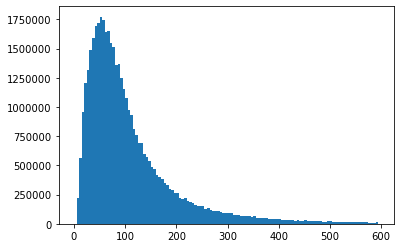

In [19]:
plt.hist(train['price'].values, bins=list(range(0, 600, 5)))

In [20]:
df.iloc[20: 30]

,price,quantized_price
20,92,11
21,200,17
22,139,15
23,11,0
24,15,0
25,15,0
26,45,4
27,16,0
28,17,0
29,16,0


In [46]:
%%time
procs = [FillMissing,Categorify]
train['is_va'] = train.row_id%5 == 0

test_list = TabularList.from_df(test, path='./', cat_names=cat_names+cont_names)

data_tab = (TabularList.from_df(train, path='./', cat_names=cat_names+cont_names, procs=procs)
                           .split_from_df('is_va')
                           .label_from_df(cols='target')
                           .add_test(test_list)
                           .databunch(num_workers=10,bs=1024))

CPU times: user 4min 13s, sys: 5min 6s, total: 9min 19s
Wall time: 9min 20s


In [47]:
%%time 
write_pkl(data_tab)
del data_pair

CPU times: user 26.1 s, sys: 1min 5s, total: 1min 31s
Wall time: 1min 48s


In [49]:
%%time
emb_szs = {'user_id': 32,'item_id':32,'platform':4,'city':8,'device':1,
                   'current_filters':8}
emb_szs.update({c: 5 for c in cont_names})
learn = tabular_learner(data_tab, layers=[128,64], metrics=None, callback_fns=AUROC,#wd=0.2,
        emb_szs = emb_szs)

CPU times: user 8.5 s, sys: 3.74 s, total: 12.2 s
Wall time: 12.7 s


In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


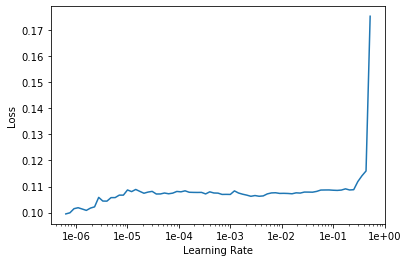

In [63]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(1, max_lr=slice(1e-2), callbacks=[SaveModelCallback(learn,
        every='improvement', monitor='AUROC',name='tab_nn_quantile')])

epoch,train_loss,valid_loss,AUROC,time
0,0.110583,0.106902,0.914721,1:00:52


Better model found at epoch 0 with AUROC value: 0.9147205802980725.


In [60]:
learn.save("trained_fastai_context_and_quantized_1_epoch")

<h2> Performance Evaluation</h2>

In [55]:
%%time
yp,y_valid = learn.get_preds()

CPU times: user 1min, sys: 49.8 s, total: 1min 50s
Wall time: 2min 7s


In [56]:
%%time
cv = train.loc[train['is_va']>0,['row_id','reference','item_id']].copy()
cv['prob'] = yp.numpy()[:,1]
cv = cv.sort_values(by=['row_id','prob'],ascending=False)
print('here')
# del train

here
CPU times: user 12.9 s, sys: 8.2 s, total: 21.1 s
Wall time: 21.4 s


In [58]:
cv['row_id'] = cv['row_id'].astype('int32')
cv['reference'] = cv['reference'].astype('int32')
cv['item_id'] = cv['item_id'].astype('int32')

In [59]:
%%time
auc = roc_auc_score(y_valid.numpy().ravel(),yp.numpy()[:,1])
mean_reciprocal_rank = get_mean_reciprocal_rank(cv)
print('mean_reciprocal_rank %.4f, AUC %.4f'%(mean_reciprocal_rank,auc))

mean_reciprocal_rank 0.6312, AUC 0.9147
CPU times: user 5.53 s, sys: 2.37 s, total: 7.9 s
Wall time: 8.7 s


In [64]:
%%time
yps,_ = learn.get_preds(DatasetType.Test)

CPU times: user 40.8 s, sys: 36 s, total: 1min 16s
Wall time: 1min 28s


In [65]:
%%time
test['target'] = yps.numpy()[:,1]
test = test['row_id,user_id,session_id,timestamp,step,item_id,target'.split(',')]
test.head()

CPU times: user 944 ms, sys: 1.54 s, total: 2.49 s
Wall time: 2.49 s


In [66]:
%%time
test = test.sort_values(by=['row_id','target'],ascending=False) # larger probs first

CPU times: user 4.55 s, sys: 1.22 s, total: 5.77 s
Wall time: 5.77 s


In [67]:
test.head()

,row_id,user_id,session_id,timestamp,step,item_id,target
48512154,2115364,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,109974,0.205580
48512153,2115364,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,46149,0.129749
48512162,2115364,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,46144,0.075075
48512157,2115364,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,12455,0.037099
48512163,2115364,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,1345912,0.024199


In [68]:
%%time
sub = test[['row_id','item_id']].copy()
sub = sub.groupby('row_id')['item_id'].apply(lambda x: ' '.join([str(i) for i in x]))
sub = sub.to_frame()
sub.columns = ['new_item_recommendations']
sub = sub.reset_index()

test = test.drop_duplicates(subset=['row_id'])
sub = test.merge(sub,on='row_id',how='left')
sub = sub[['session_id','new_item_recommendations']]

CPU times: user 22.8 s, sys: 1.41 s, total: 24.2 s
Wall time: 24.2 s


In [69]:
%%time
sample_sub = pd.read_csv('/datasets/trivago/data/submission_popular.csv')
# sample_sub = pd.read_csv('../input/submission_popular.csv')
assert sample_sub.shape[0] == sample_sub.session_id.unique().shape[0]
sub = sample_sub.merge(sub,on='session_id',how='left')

from datetime import datetime
clock = "{}".format(datetime.now()).replace(' ','-').replace(':','-').split('.')[0]

mask = sub.new_item_recommendations.isnull() == 0
sub.loc[mask,'item_recommendations'] = sub.loc[mask,'new_item_recommendations']
sub = sub.drop('new_item_recommendations',axis=1)
out = 'fastai_%s_mrr_%.4f_auc_%.4f.csv'%(clock,mean_reciprocal_rank,auc)
sub.to_csv(out,index=False)

sub.head()

CPU times: user 2.82 s, sys: 516 ms, total: 3.33 s
Wall time: 3.42 s
